#[Problem 1] Classifying fully connected layers

In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [2]:

class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        self.optimizer = optimizer
        self.HW = 0
        self.HB = 0

    def forward(self, X):
        self.Z = X
        self.A = self.Z @ self.W + self.B
        return self.A

    def backward(self, dA):
        self.dB = np.sum(dA, axis=0)
        self.dW = self.Z.T @ dA
        self.dZ = dA @ self.W.T
        # Update weights and biases using the optimizer
        self.W, self.B = self.optimizer.update(self.W, self.B, self.dW, self.dB)
        return self.dZ


#[Problem 2] Classifying the initialization method

In [3]:
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B


#[Problem 3] Classifying optimization methods

In [4]:
class SGD:
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.W -= self.lr * layer.dW / len(layer.Z)
        layer.B -= self.lr * layer.dB / len(layer.Z)
        return layer


#[Problem 4] Classifying activation functions

In [5]:
class Sigmoid:
    def forward(self, A):
        self.A = A
        self.Z = 1 / (1 + np.exp(-self.A))
        return self.Z

    def backward(self, dZ):
        sigmoid_derivative = self.Z * (1 - self.Z)
        dA = dZ * sigmoid_derivative
        return dA

In [6]:
class Tanh:
    def forward(self, A):
        self.A = A
        self.Z = np.tanh(self.A)
        return self.Z

    def backward(self, dZ):
        tanh_derivative = 1 - np.tanh(self.A)**2
        dA = dZ * tanh_derivative
        return dA

In [7]:
class SoftmaxWithCrossEntropyLoss:
    def forward(self, A, y):
        self.A = A
        self.y = y
        exp_A = np.exp(A - np.max(A, axis=1, keepdims=True))  # For numerical stability
        self.Z = exp_A / np.sum(exp_A, axis=1, keepdims=True)
        loss = -np.sum(y * np.log(self.Z + 1e-15)) / len(y)  # Cross-entropy loss
        return self.Z, loss

    def backward(self):
        dA = self.Z - self.y
        return dA


In [8]:
def softmax(z):
    exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))  # Subtract max for numerical stability
    probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probabilities



#[Problem 5] ReLU class creation

In [9]:
class ReLU:
    def forward(self, A):
        self.A = A
        Z = np.maximum(0, A)
        return Z

    def backward(self, dZ):
        dA = dZ * np.where(self.A > 0, 1, 0)
        return dA


#[Problem 6] Initial value of weight

In [10]:
class XavierInitializer:
    def __init__(self):
        pass

    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(1 / n_nodes1)
        W = sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = np.zeros((1, n_nodes2))
        return B

In [11]:
class HeInitializer:
    def __init__(self):
        pass

    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(2 / n_nodes1)
        W = sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = np.zeros((1, n_nodes2))
        return B


#[Problem 7] Optimization method

In [12]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.HW = None
        self.HB = None

    def update(self, layer):
        if self.HW is None:
            self.HW = np.zeros_like(layer.W)
        if self.HB is None:
            self.HB = np.zeros_like(layer.B)

        self.HW += layer.dW ** 2
        self.HB += layer.dB ** 2

        delta = 1e-7
        layer.W -= self.lr * layer.dW / (np.sqrt(self.HW) + delta)
        layer.B -= self.lr * layer.dB / (np.sqrt(self.HB) + delta)

        return layer


#[Problem 8] Class completion

In [13]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0] / self.batch_size).astype(np.int64)

    def __len__(self):
        return self._stop

    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = p0 + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = p0 + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [14]:
class ScratchSimpleNeuralNetworkClassifier:
    def __init__(self, verbose=False, epoch=1, initializer=None, optimizer=None, activater=None):
        self.verbose = verbose
        self.batch_size = 20
        self.n_features = 784
        self.n_nodes1 = 600
        self.n_nodes2 = 200
        self.n_output = 10
        self.sigma = 0.02
        self.lr = 0.5
        self.epoch = epoch
        self.initializer = initializer
        self.optimizer = optimizer
        self.activater = activater

    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_train = []
        self.loss_val = []
        optimizer = self.optimizer(self.lr)

        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer(self.sigma), optimizer)
        self.activation1 = self.activater()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), optimizer)
        self.activation2 = self.activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation3 = Softmax()

        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)

            for mini_x, mini_y in get_mini_batch:
                # Forward pass
                A1 = self.FC1.forward(mini_x)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)

                # Compute loss and gradients
                dA3 = self.activation3.backward(Z3, mini_y)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1)

                # Update weights and biases
                self.FC1 = self.FC1.optimizer.update(self.FC1)
                self.FC2 = self.FC2.optimizer.update(self.FC2)
                self.FC3 = self.FC3.optimizer.update(self.FC3)

            if self.verbose:
                # Compute and store training loss
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                self.loss_train.append(self.activation3.backward(Z3, y)[1])

            if X_val is not None and y_val is not None:
                # Compute and store validation loss
                A1 = self.FC1.forward(X_val)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                self.loss_val.append(self.activation3.backward(Z3, y_val)[1])

    def predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return np.argmax(Z3, axis=1)


#[Problem 9] Learning and estimation

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training ReLU_Xavier_SGD...


<ipython-input-15-f888654e0944>:101: RuntimeWarning: overflow encountered in matmul
  self.dX = dA @ self.W.T
<ipython-input-15-f888654e0944>:25: RuntimeWarning: invalid value encountered in multiply
  return dZ * (self.A > 0)


ReLU_Xavier_SGD Accuracy: 0.0980
Training ReLU_He_SGD...
ReLU_He_SGD Accuracy: 0.1009
Training Sigmoid_Xavier_SGD...


<ipython-input-15-f888654e0944>:30: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-A))


Sigmoid_Xavier_SGD Accuracy: 0.1009
Training Tanh_Xavier_SGD...
Tanh_Xavier_SGD Accuracy: 0.0892


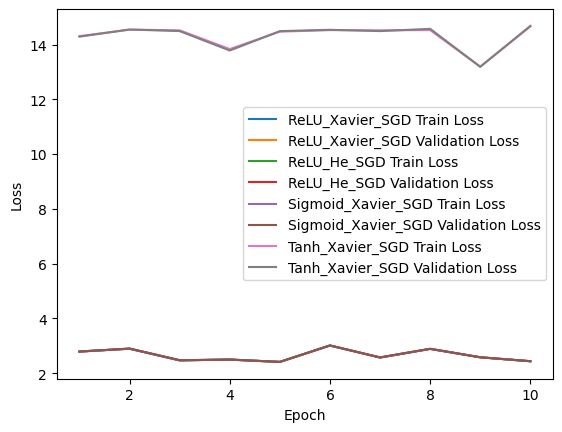

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder

# Load and preprocess MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape and normalize data
X_train = X_train.reshape(-1, 784).astype(np.float64) / 255
X_test = X_test.reshape(-1, 784).astype(np.float64) / 255

# One-hot encode labels
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# Define activation functions and initializers
class ReLU:
    def forward(self, A):
        self.A = A
        return np.maximum(0, A)

    def backward(self, dZ):
        return dZ * (self.A > 0)

class Sigmoid:
    def forward(self, A):
        self.A = A
        return 1 / (1 + np.exp(-A))

    def backward(self, dZ):
        sig = self.forward(self.A)
        return dZ * sig * (1 - sig)

class Tanh:
    def forward(self, A):
        self.A = A
        return np.tanh(A)

    def backward(self, dZ):
        return dZ * (1 - np.tanh(self.A)**2)

class Softmax:
    def forward(self, A):
        self.A = A
        exp_scores = np.exp(A - np.max(A, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def backward(self, Z, y):
        m = y.shape[0]
        dZ = Z - y
        loss = -np.sum(y * np.log(Z + 1e-7)) / m
        return dZ, loss

class XavierInitializer:
    def __init__(self, sigma=0.02):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(1, n_nodes2)

class HeInitializer:
    def __init__(self, sigma=0.02):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        return np.sqrt(2 / n_nodes1) * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return np.zeros((1, n_nodes2))

class SGD:
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.optimizer = optimizer

    def forward(self, X):
        self.X = X
        self.Z = X @ self.W + self.B
        return self.Z

    def backward(self, dA):
        self.dB = np.sum(dA, axis=0, keepdims=True)
        self.dW = self.X.T @ dA
        self.dX = dA @ self.W.T
        return self.dX

    def update(self):
        self.optimizer.update(self)
        return self

class ScratchSimpleNeuralNetworkClassifier:
    def __init__(self, verbose=False, epoch=1, initializer=None, optimizer=None, activater=None):
        self.verbose = verbose
        self.batch_size = 20
        self.n_features = 784
        self.n_nodes1 = 600
        self.n_nodes2 = 200
        self.n_output = 10
        self.sigma = 0.02
        self.lr = 0.5
        self.epoch = epoch
        self.initializer = initializer
        self.optimizer = optimizer
        self.activater = activater

    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_train = []
        self.loss_val = []
        optimizer = self.optimizer(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer(self.sigma), optimizer)
        self.activation1 = self.activater()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), optimizer)
        self.activation2 = self.activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation3 = Softmax()

        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)

            for mini_x, mini_y in get_mini_batch:
                # Forward pass
                A1 = self.FC1.forward(mini_x)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)

                # Compute loss and gradients
                dA3, loss = self.activation3.backward(Z3, mini_y)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                self.FC1.backward(dA1)

                # Update weights and biases
                self.FC1.update()
                self.FC2.update()
                self.FC3.update()

            if self.verbose:
                # Compute and store training loss
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                _, loss_train = self.activation3.backward(Z3, y)
                self.loss_train.append(loss_train)

            if X_val is not None and y_val is not None:
                # Compute and store validation loss
                A1 = self.FC1.forward(X_val)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                _, loss_val = self.activation3.backward(Z3, y_val)
                self.loss_val.append(loss_val)

    def predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return np.argmax(Z3, axis=1)

# Create and train multiple models with varying configurations
def train_and_evaluate():
    models = {
        'ReLU_Xavier_SGD': ScratchSimpleNeuralNetworkClassifier(
            verbose=True, epoch=10,
            initializer=XavierInitializer,
            optimizer=SGD,
            activater=ReLU
        ),
        'ReLU_He_SGD': ScratchSimpleNeuralNetworkClassifier(
            verbose=True, epoch=10,
            initializer=HeInitializer,
            optimizer=SGD,
            activater=ReLU
        ),
        'Sigmoid_Xavier_SGD': ScratchSimpleNeuralNetworkClassifier(
            verbose=True, epoch=10,
            initializer=XavierInitializer,
            optimizer=SGD,
            activater=Sigmoid
        ),
        'Tanh_Xavier_SGD': ScratchSimpleNeuralNetworkClassifier(
            verbose=True, epoch=10,
            initializer=XavierInitializer,
            optimizer=SGD,
            activater=Tanh
        )
    }

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train_one_hot, X_val=X_test, y_val=y_test_one_hot)
        predictions = model.predict(X_test)
        accuracy = np.mean(predictions == y_test)
        print(f"{name} Accuracy: {accuracy:.4f}")

        # Plot loss curves
        plt.plot(range(1, model.epoch + 1), model.loss_train, label=f'{name} Train Loss')
        if model.loss_val:
            plt.plot(range(1, model.epoch + 1), model.loss_val, label=f'{name} Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

train_and_evaluate()
